
# 문제 정의
- 문제의 종류 
  - 부동산 가격을 예측하는 Linear Regression 문제
- 데이터셋  
<img src='https://drive.google.com/uc?export=download&id=16gEPmTgkUOS-sJLAP0f7P0yCutenO0ZS' width="" height ="" /><br>
  - 미국 시애틀의 부동산 거래 데이터셋
  - 데이터 수집 과정에 대한 설명이 없음.
  - 입력 데이터
    - ID : 집을 구분하는 번호(사용X)
    - date : 집을 구매한 날짜
    - price : 타겟 변수인 집의 가격
    - bedrooms : 침실의 수
    - bathrooms : 침실당 화장실 개수
    - sqft_living : 주거 공간의 평방 피트
    - sqft_lot : 부지의 평방 피트
    - floors : 집의 층 수
    - waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
    - view : 집이 얼마나 좋아 보이는지의 정도
    - condition : 집의 전반적인 상태
    - grade : King County grading 시스템 기준으로 매긴 집의 등급
    - sqft_above : 지하실을 제외한 평방 피트
    - sqft_basement : 지하실의 평방 피트
    - yr_built : 집을 지은 년도
    - yr_renovated : 집을 재건축한 년도
    - zipcode : 우편번호(사용X)
    - lat : 위도
    - long : 경도
    - sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
    - sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
  - 출력 데이터
    - 예상 부동산 가격


### 구글 드라이브 연동

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
!ls '/gdrive/MyDrive/0. 인공지능 학습/아이펠 대전 3기/2. Exploration 수업/코드/4강'

2019-ml-month-2nd-baseline.ipynb  data	    project4_2.ipynb
baseline_ex1.ipynb		  ex.ipynb  project4.ipynb
baseline_ex2_tuned.ipynb	  image


### Colab의 패키지 버전을 최신 버전으로 업그레이드

In [3]:
!pip install --upgrade xgboost
!pip install --upgrade lightgbm
!pip install --upgrade missingno

### 모듈 로드

In [4]:
import xgboost as xgb
import lightgbm as lgb
import missingno as msno

print(xgb.__version__)
print(lgb.__version__)
print(msno.__version__)

1.6.1
3.3.2
0.5.1


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

### 데이터 로드

In [7]:
# 데이터셋 경로
base_dir = '/gdrive/MyDrive/0. 인공지능 학습/아이펠 대전 3기/2. Exploration 수업/코드/4강'
train_data_path = os.path.join(base_dir, "data/train.csv")
test_data_path = os.path.join(base_dir, "data/test.csv")
# print(train_data_path)
# print(test_data_path)

# 캐글 제출용 샘플 파일 주소
sample_submission_path = os.path.join(base_dir, "data/sample_submission.csv")
# print(sample_submission_path)

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [8]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 상관관계 분석
  - 전체 상관관계를 먼저 분석해본 결과 실거주요소와 관련된 상관관계는 높게 나타났다.
  - 부지, 집의상태, 집의 건축/재건축 년도, zipcode 등은 약한 상관관계를 보인다.

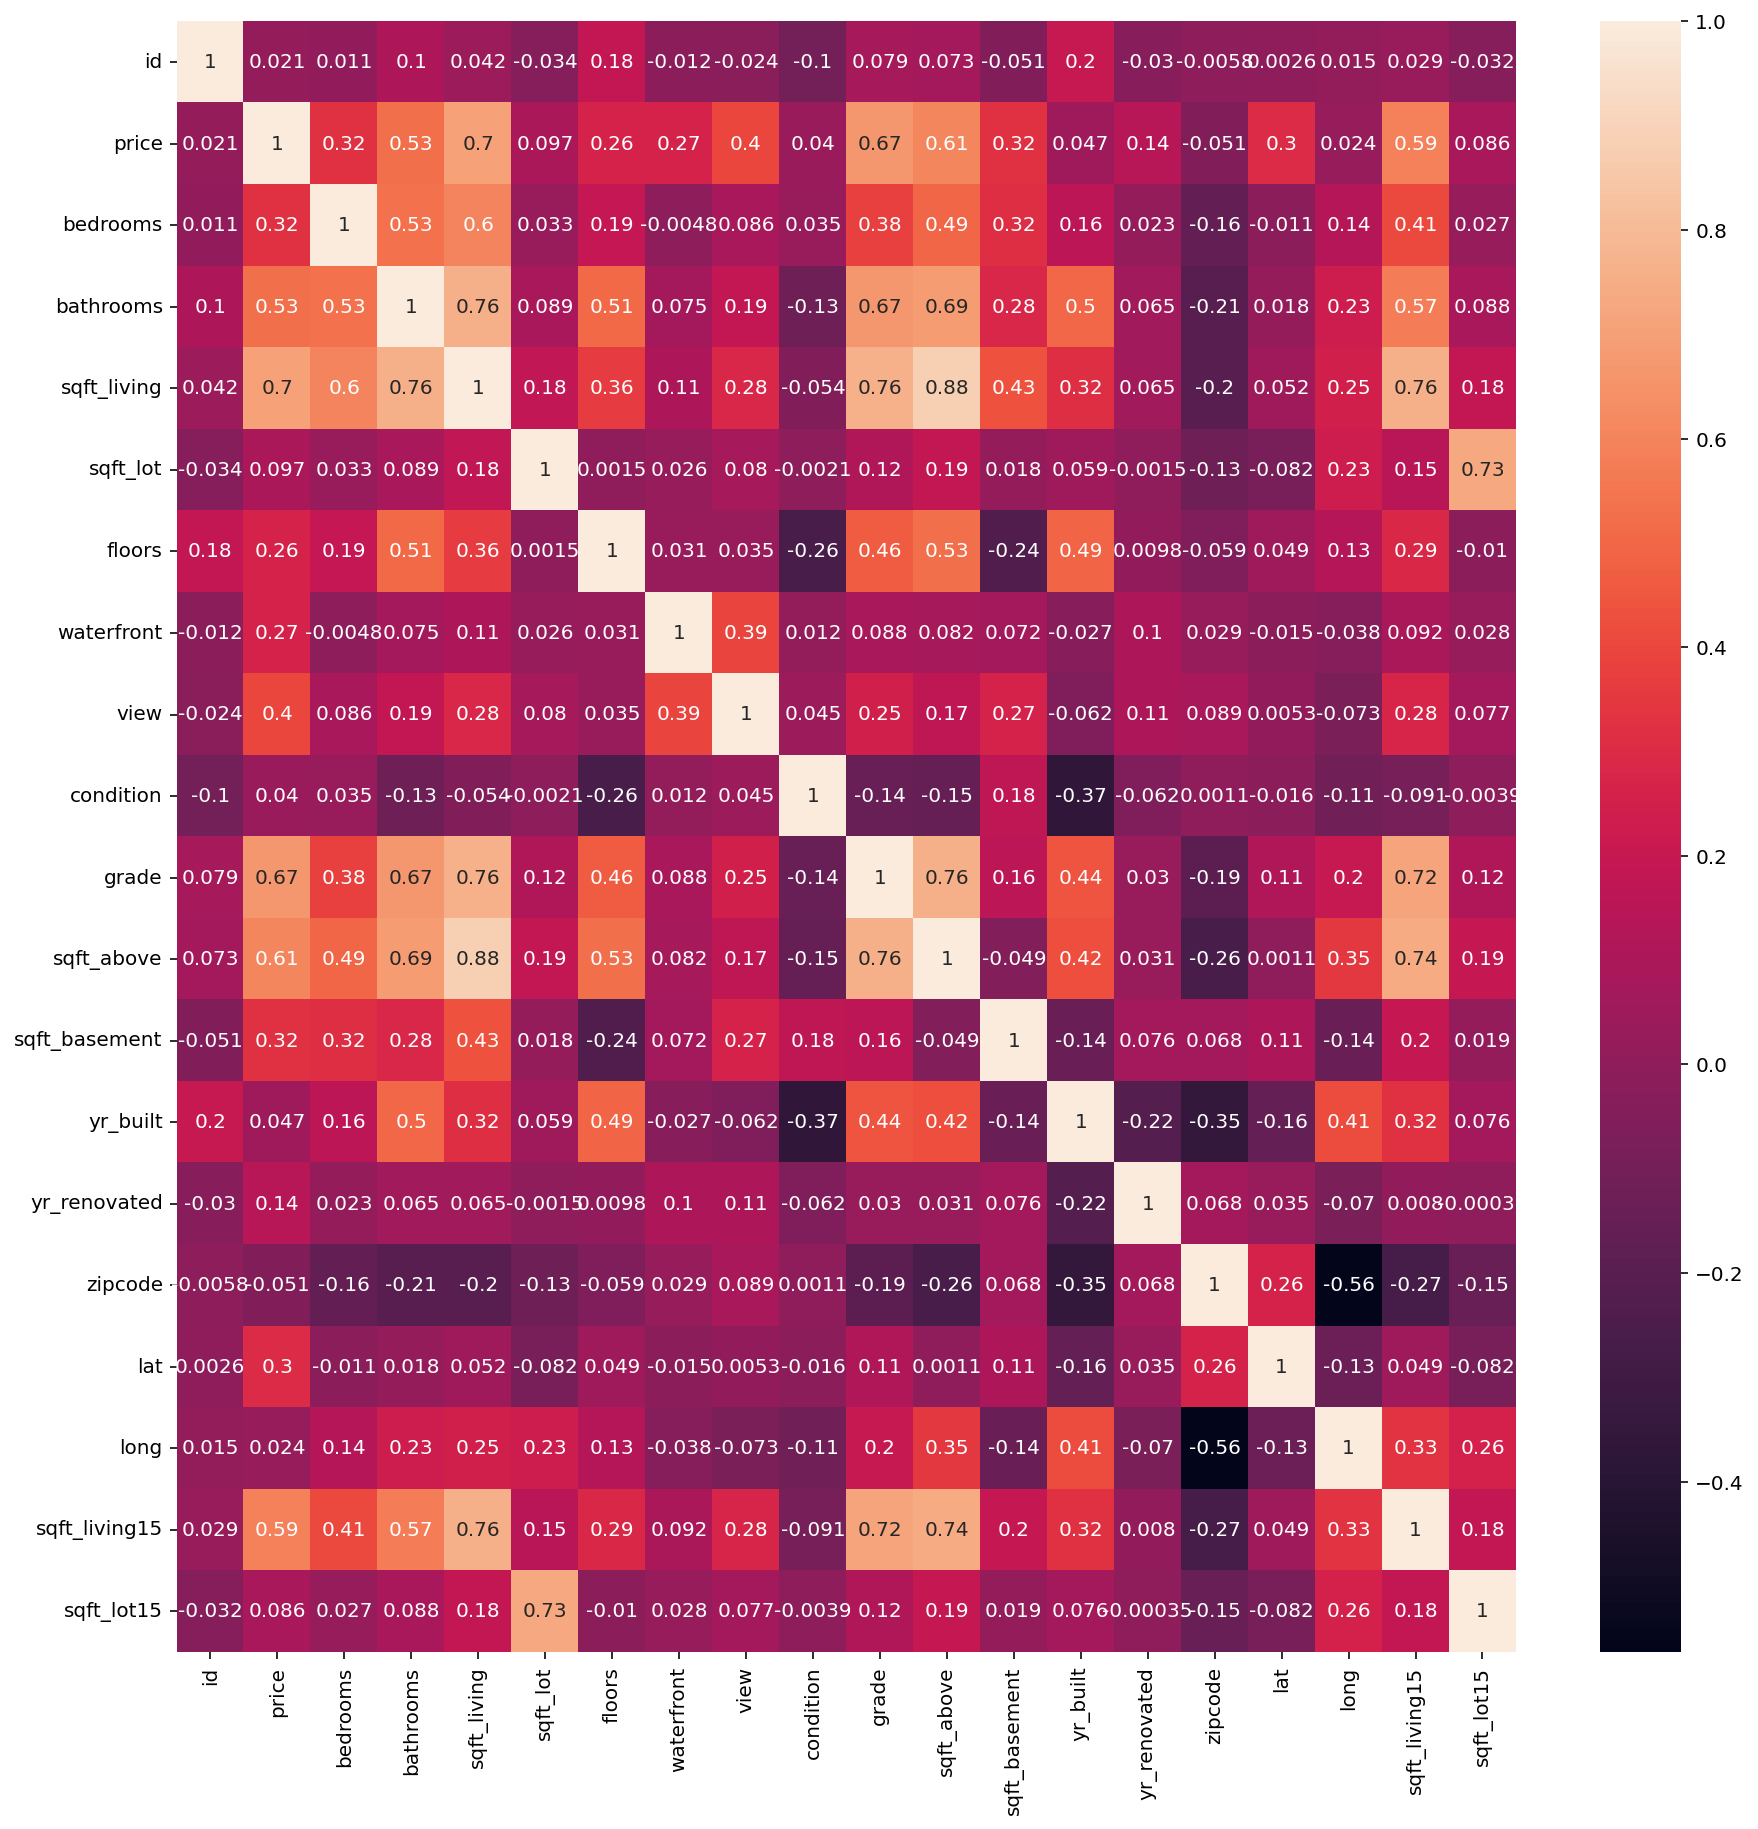

In [9]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(), annot=True)

In [10]:
del train["sqft_lot"]
del train["condition"]
del train["yr_built"]
del train["yr_renovated"]
del train["zipcode"]
del train["sqft_lot15"]

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,sqft_above,sqft_basement,lat,long,sqft_living15
0,0,20141013T000000,221900.0,3,1.00,1180,1.0,0,0,7,1180,0,47.5112,-122.257,1340
1,1,20150225T000000,180000.0,2,1.00,770,1.0,0,0,6,770,0,47.7379,-122.233,2720
2,2,20150218T000000,510000.0,3,2.00,1680,1.0,0,0,8,1680,0,47.6168,-122.045,1800
3,3,20140627T000000,257500.0,3,2.25,1715,2.0,0,0,7,1715,0,47.3097,-122.327,2238
4,4,20150115T000000,291850.0,3,1.50,1060,1.0,0,0,7,1060,0,47.4095,-122.315,1650


In [11]:
del test["sqft_lot"]
del test["condition"]
del test["yr_built"]
del test["yr_renovated"]
del test["zipcode"]
del test["sqft_lot15"]

test.head()

,id,date,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,sqft_above,sqft_basement,lat,long,sqft_living15
0,15035,20141209T000000,3,2.25,2570,2.0,0,0,7,2170,400,47.7210,-122.319,1690
1,15036,20141209T000000,4,3.00,1960,1.0,0,0,7,1050,910,47.5208,-122.393,1360
2,15037,20140512T000000,4,4.50,5420,1.0,0,0,11,3890,1530,47.6561,-122.005,4760
3,15038,20150415T000000,3,1.00,1780,1.0,0,0,7,1050,730,47.5123,-122.337,1780
4,15039,20150312T000000,3,2.50,1890,2.0,0,0,7,1890,0,47.3684,-122.031,2390


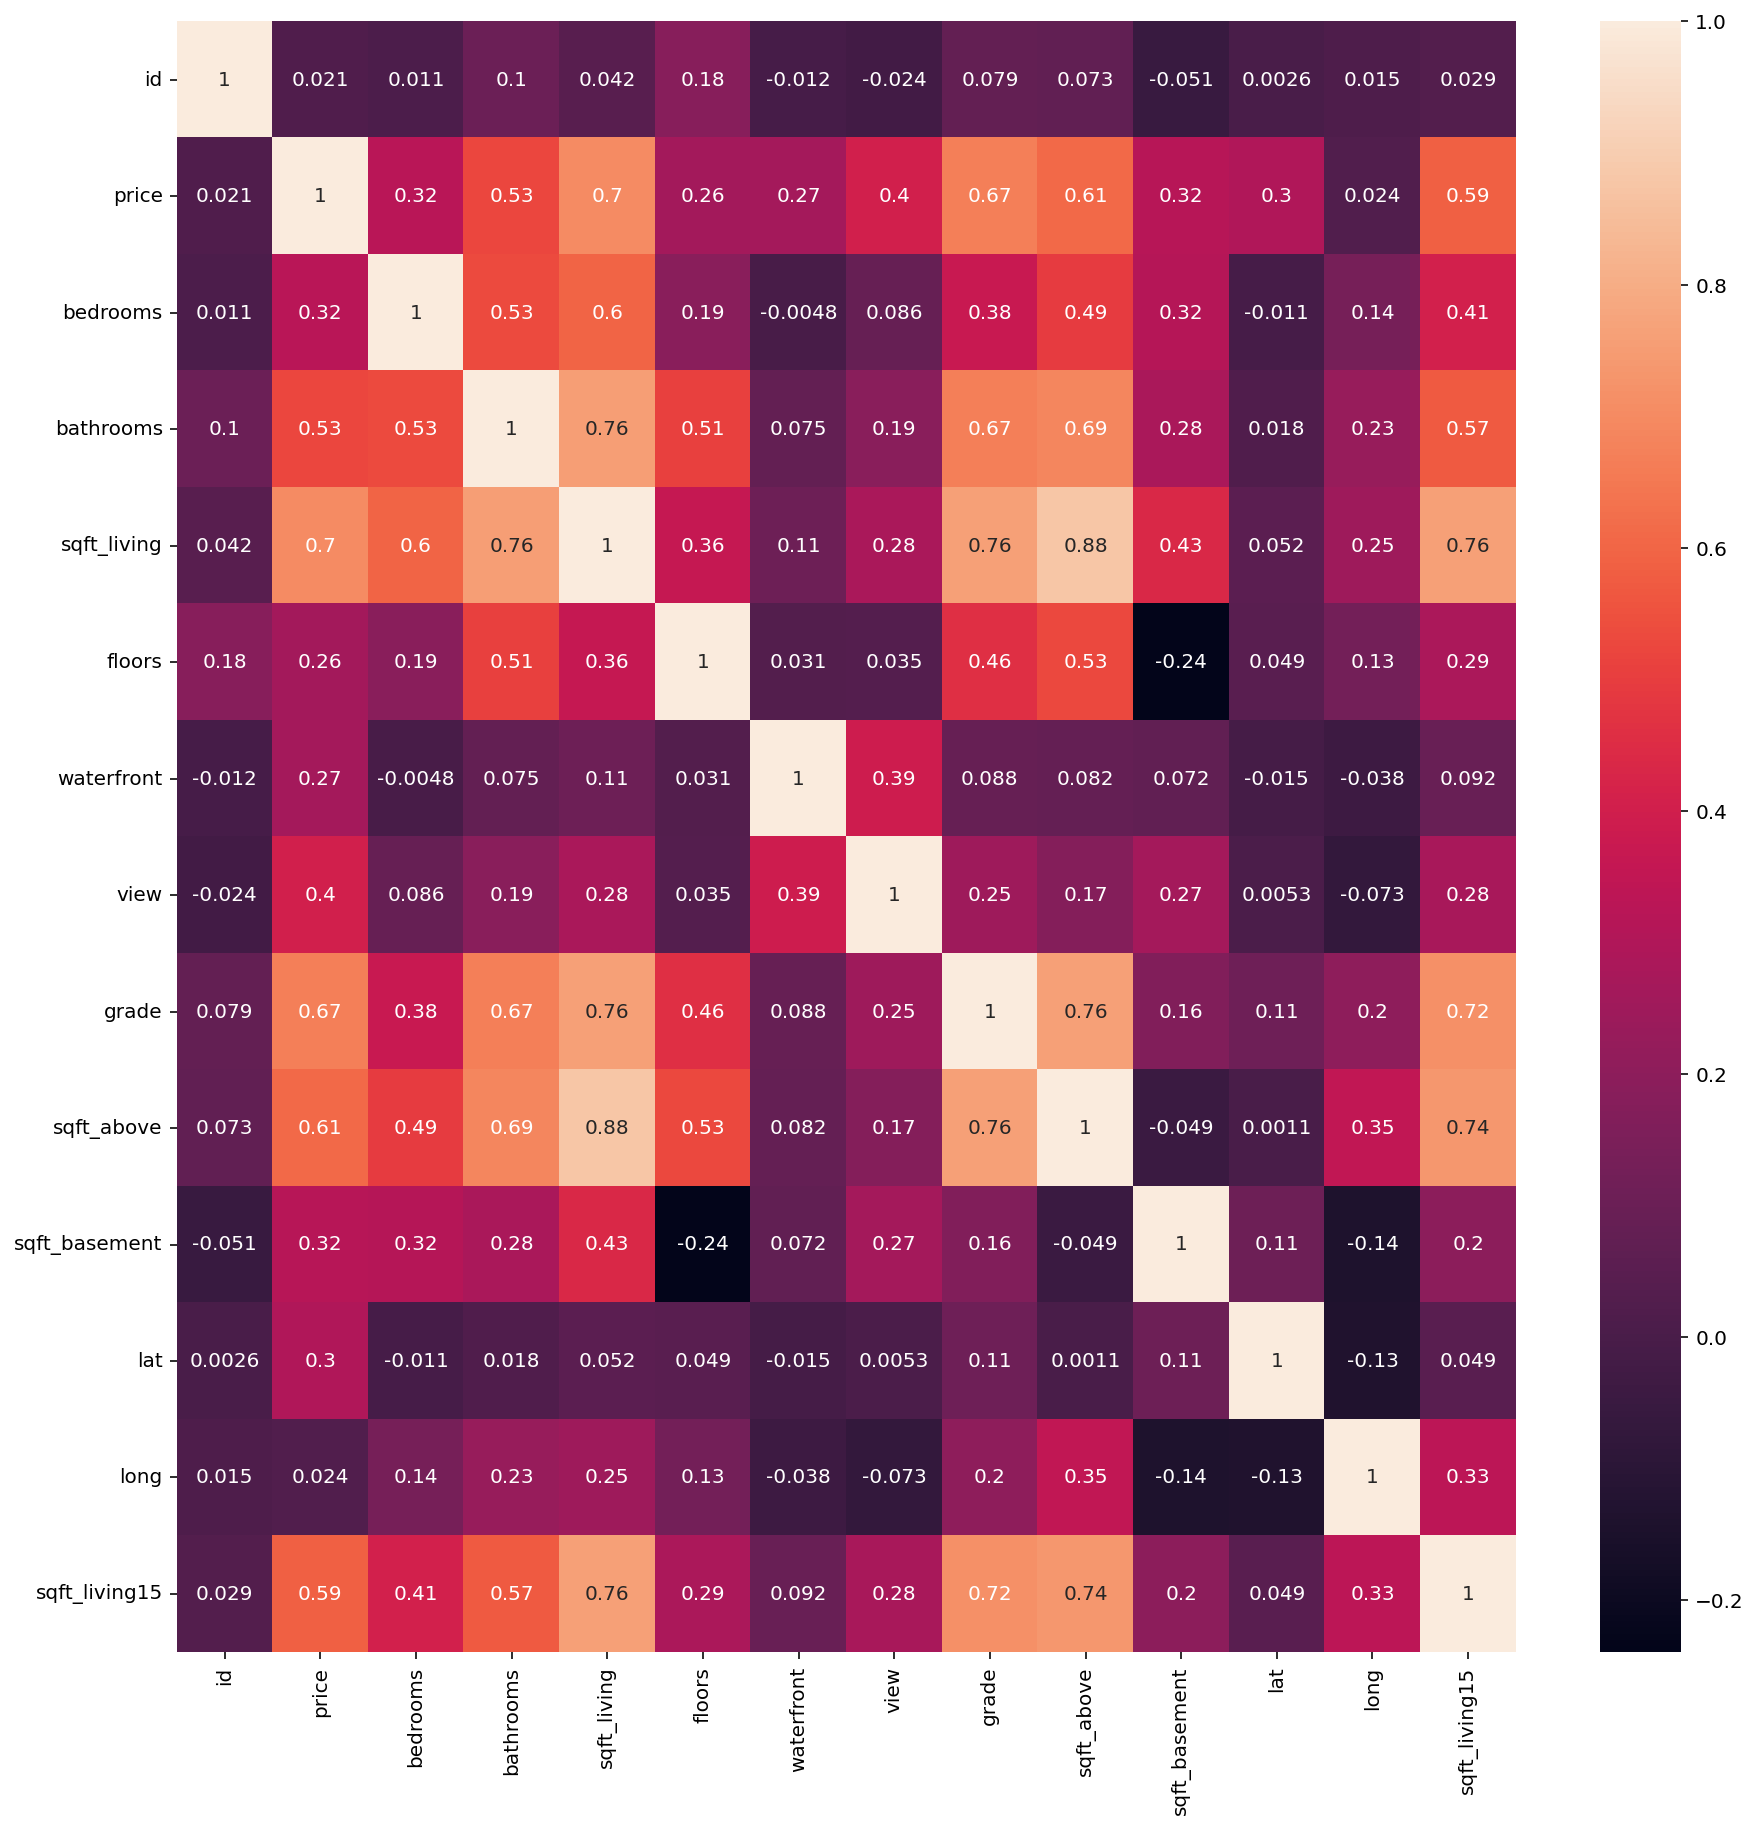

In [12]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(), annot=True)

### 날짜 변환
- date
  - 너무 세세한 데이터는 학습에 오히려 방해가 될지도 모른다.
  - 따라서 연/월/일/시 중 거래가 이루어진 연도와 달의 데이터만 사용하기로 함.
  - apply, lambda를 이용하여 데이터를 수정함.
  - 부동산 가격은 변동은 있기는 하나 우상향하기 때문에 경진대회가 이루어진 2019년으로부터 얼마나 멀리 떨어진 시점에서 거래가 이루어졌는지 판단하기 위해 거래 시기를 아래와 같이 표현함.

In [13]:
# date 변환
train['year'] = train['date'].apply(lambda i: i[:4]).astype(float)
train['month'] = train['date'].apply(lambda i: i[4:6]).astype(float) / 12
train['year_month'] = train['year'] + train['month'] - 2019

# 필요 없는 데이터 삭제
del train['date']
del train['year']
del train['month']

# train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

train.head()

,id,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,sqft_above,sqft_basement,lat,long,sqft_living15,year_month
0,0,221900.0,3,1.00,1180,1.0,0,0,7,1180,0,47.5112,-122.257,1340,-4.166667
1,1,180000.0,2,1.00,770,1.0,0,0,6,770,0,47.7379,-122.233,2720,-3.833333
2,2,510000.0,3,2.00,1680,1.0,0,0,8,1680,0,47.6168,-122.045,1800,-3.833333
3,3,257500.0,3,2.25,1715,2.0,0,0,7,1715,0,47.3097,-122.327,2238,-4.500000
4,4,291850.0,3,1.50,1060,1.0,0,0,7,1060,0,47.4095,-122.315,1650,-3.916667


In [14]:
# date 변환
test['year'] = test['date'].apply(lambda i: i[:4]).astype(float)
test['month'] = test['date'].apply(lambda i: i[4:6]).astype(float) / 12
test['year_month'] = test['year'] + test['month'] - 2019

# 필요 없는 데이터 삭제
del test['date']
del test['year']
del test['month']

# test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

test.head()

,id,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,sqft_above,sqft_basement,lat,long,sqft_living15,year_month
0,15035,3,2.25,2570,2.0,0,0,7,2170,400,47.7210,-122.319,1690,-4.000000
1,15036,4,3.00,1960,1.0,0,0,7,1050,910,47.5208,-122.393,1360,-4.000000
2,15037,4,4.50,5420,1.0,0,0,11,3890,1530,47.6561,-122.005,4760,-4.583333
3,15038,3,1.00,1780,1.0,0,0,7,1050,730,47.5123,-122.337,1780,-3.666667
4,15039,3,2.50,1890,2.0,0,0,7,1890,0,47.3684,-122.031,2390,-3.750000


### 데이터 변환
- 훈련 데이터에서 price를 분리하여 target 데이터를 생성한다.
- 불필요한 id와 price를 훈련 데이터에서 삭제한다.

In [15]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'view', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long',
       'sqft_living15', 'year_month'],
      dtype='object')


In [16]:
del train['id']

print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15',
       'year_month'],
      dtype='object')


In [17]:
del test['id']

print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15',
       'year_month'],
      dtype='object')


### 타겟 데이터 정규화
- 타겟 데이터의 편향된 분포를 정규화하고 훈련 시 타겟 데이터가 너무 커서 연산이 멈추는 일을 방지하기 위해 정규화 수행함.

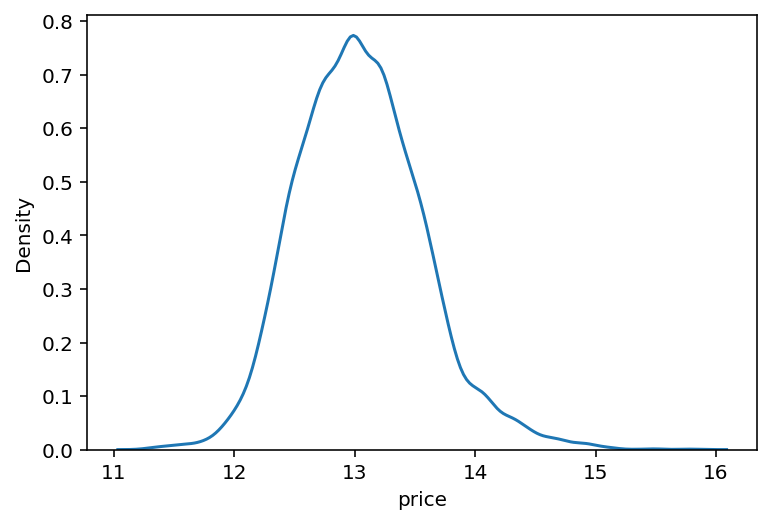

In [18]:
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       15035 non-null  int64  
 1   bathrooms      15035 non-null  float64
 2   sqft_living    15035 non-null  int64  
 3   floors         15035 non-null  float64
 4   waterfront     15035 non-null  int64  
 5   view           15035 non-null  int64  
 6   grade          15035 non-null  int64  
 7   sqft_above     15035 non-null  int64  
 8   sqft_basement  15035 non-null  int64  
 9   lat            15035 non-null  float64
 10  long           15035 non-null  float64
 11  sqft_living15  15035 non-null  int64  
 12  year_month     15035 non-null  float64
dtypes: float64(5), int64(8)
memory usage: 1.5 MB


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       6468 non-null   int64  
 1   bathrooms      6468 non-null   float64
 2   sqft_living    6468 non-null   int64  
 3   floors         6468 non-null   float64
 4   waterfront     6468 non-null   int64  
 5   view           6468 non-null   int64  
 6   grade          6468 non-null   int64  
 7   sqft_above     6468 non-null   int64  
 8   sqft_basement  6468 non-null   int64  
 9   lat            6468 non-null   float64
 10  long           6468 non-null   float64
 11  sqft_living15  6468 non-null   int64  
 12  year_month     6468 non-null   float64
dtypes: float64(5), int64(8)
memory usage: 657.0 KB


### 학습 모델 준비
- GradientBoostingRegressor, XGBRegressor, LGBMRegressor, RandomForestRegressor 등의 모델을 이용하여 모델을 학습 및 평가한다.
- 학습 결과에 대한 평가는 RMSE로 수행한다.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [22]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [23]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [24]:
random_state=1000

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [25]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,137594.761050
RandomForestRegressor,135348.806881
LGBMRegressor,129980.330430
XGBRegressor,124920.486398


### 하이퍼 파라미터 튜닝을 통한 성능 향상 수행
- 그리드 서치 기능을 통하여 하이퍼 파라미터를 최적화한다.

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(
        model, 
        param_grid=param_grid, 
        scoring='neg_mean_squared_error', 
        cv=5, 
        verbose=verbose, 
        n_jobs=n_jobs
    )
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [28]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.030807,0.175519
2,10,50,-0.032159,0.179329
1,1,100,-0.055623,0.235845
0,1,50,-0.073394,0.270914


In [29]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.12743855, 12.99150564, 14.12169804, ..., 13.06576187,
       12.64274286, 12.99805427])

In [30]:
prediction = np.expm1(prediction)
prediction

array([ 502543.03868266,  438670.28878604, 1358235.93172544, ...,
        472484.27967823,  309508.12661293,  441552.41079138])

### 캐글 제출 파일 생성

In [32]:
submission = pd.read_csv(sample_submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [33]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.025430e+05
1,15036,4.386703e+05
2,15037,1.358236e+06
3,15038,3.241003e+05
4,15039,3.364262e+05


In [34]:
submission.to_csv(sample_submission_path, index=False)

<img src='https://drive.google.com/uc?export=download&id=17shqZ-aQq3hASYqtALChUpZZNeJAIgYv' width="" height ="" /><br>

- 테스트 결과 이미지 링크
- https://drive.google.com/file/d/17shqZ-aQq3hASYqtALChUpZZNeJAIgYv/view?usp=sharing

### 학습 결과
- 미국 시애틀 부동산에 대한 부동산 가격 예측을 수행하였음.
- 학습 데이터 중 중요도가 떨어진다고 생각하는 몇가지 입력 파라미터를 제외한 데이터를 사용하였음.
- 여러 모델을 혼용하는 앙상블 기법을 적용하였으며 학습 모델로는 GradientBoostingRegressor, XGBRegressor, LGBMRegressor, RandomForestRegressor 등을 사용하였음.
- 평가 함수는 RMSE를 사용하였음.
- 그리드 서치 기법을 이용하여 하이퍼 파라미터 최적화를 수행하였음.
- 훈련된 모델에 대하여 테스트를 수행한 결과 115807의 점수를 얻었음.

### 회고
- 베이스라인을 기준으로 데이터 전처리, 하이퍼 파라미터 튜닝 등 추가적인 조치를 취했으나 성능이 향상되는 결과는 얻지 못하였음.
- 캐글에서 제공하는 데이터들은 고차원적인 특징을 가지는 데이터이기 때문에 수준 낮은 모델로 이들 사이의 상관관계를 분석하여 결과를 정확하게 예측하기란 어려운 일이라고 생각함.
- 이런 문제를 해결하기 위해 단순히 모델에 의존하는 것이 아니라 수학적 기법을 동원하여 지역별 부동산 가격의 분포도 혹은 해당 지역 부동산의 평당 가격 등을 계산 후 학습에 이용하는 듯 함.
- 필자는 이에 대한 대안으로 위도, 경도로 표시되는 좌표에 대해 가격의 분포를 K-Means Clustering으로 예측하려 했으나 시간 부족으로 더 이상 진행은 하지 못하였음.
- 나중에 개인적으로 더 진행해보도록 하겠음.